# [1] Visualize per-pixel lighting

In [10]:
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os.path as osp
import numpy as np
import cv2
from skimage.measure import block_reduce 

envHeight = 8
envWidth = 16
envRow = 120
envCol = 160
SGNum = 12

def loadEnvmap(envName ):
    print('>>>>loadEnvmap', envName)
    if not osp.isfile(envName ):
        env = np.zeros( [3, envRow, envCol,
            envHeight, envWidth], dtype = np.float32 )
        envInd = np.zeros([1, 1, 1], dtype=np.float32 )
        print('Warning: the envmap %s does not exist.' % envName )
        return env, envInd
    else:
        envHeightOrig, envWidthOrig = 16, 32
        assert( (envHeightOrig / envHeight) == (envWidthOrig / envWidth) )
        assert( envHeightOrig % envHeight == 0)

        env = cv2.imread(envName, -1 ) 
        print(env.shape)

        if not env is None:
            env = env.reshape(envRow, envHeightOrig, envCol,
                envWidthOrig, 3) # (1920, 5120, 3) -> (120, 16, 160, 32, 3)
            env = np.ascontiguousarray(env.transpose([4, 0, 2, 1, 3] ) ) # -> (3, 120, 160, 16, 32)

            scale = envHeightOrig / envHeight
            if scale > 1:
                env = block_reduce(env, block_size = (1, 1, 1, 2, 2), func = np.mean )

            envInd = np.ones([1, 1, 1], dtype=np.float32 )
            return env, envInd
        else:
            env = np.zeros( [3, envRow, envCol,
                envHeight, envWidth], dtype = np.float32 )
            envInd = np.zeros([1, 1, 1], dtype=np.float32 )
            print('Warning: the envmap %s does not exist.' % envName )
            return env, envInd

from pathlib import Path
meta_split, scene_name, png_file_name = ('mainDiffLight_xml1', 'scene0552_00', 'im_6.png')
# meta_split, scene_name, png_file_name = ('mainDiffMat_xml1', 'scene0695_03', 'im_26.png')



root_path = Path('/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/')
env_path = root_path / meta_split / scene_name / (png_file_name.replace('im_', 'imenv_').replace('.png', '.hdr'))

# change to direct lighting; comment 3 lines to use original envmap lighting
# env_path = str(env_path).replace('imenv', 'imenvDirect')
# envRow = 120 // 4
# envCol = 160 // 4

envmaps, envmapsInd = loadEnvmap(str(env_path))


>>>>loadEnvmap /newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/mainDiffLight_xml1/scene0552_00/imenv_6.hdr
(1920, 5120, 3)


(3, 12, 16, 8, 16)


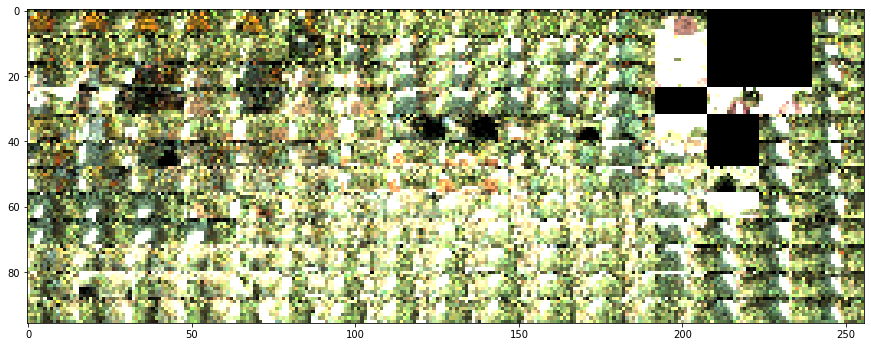

In [7]:
H_grid, W_grid, h, w = envmaps.shape[1:]
downsize_ratio = 10
assert H_grid % downsize_ratio == 0
assert W_grid % downsize_ratio == 0
xx, yy = np.meshgrid(np.arange(0, H_grid, downsize_ratio), np.arange(0, W_grid, downsize_ratio))
a = envmaps[:, xx.T, yy.T, :, :] * 0.1
a = np.clip(a**(1.0/2.2), 0., 1.)


print(a.shape)
b = a.transpose(1, 3, 2, 4, 0).reshape(H_grid*h//downsize_ratio, W_grid*w//downsize_ratio, 3)


import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.imshow(b)
plt.show()


# rendering layer

In [13]:
import numpy as np
from PIL import Image

im_width = 320
im_height = 240
bn = 1

def loadImage(imName, isGama = False):
    if not(osp.isfile(imName ) ):
        print('File does not exist: ' + imName )
        assert(False )

    im = Image.open(imName)
    im = im.resize([im_width, im_height], Image.ANTIALIAS )

    im = np.asarray(im, dtype=np.float32)
    if isGama:
        im = (im / 255.0) ** 2.2
        im = 2 * im - 1
    else:
        im = (im - 127.5) / 127.5
    if len(im.shape) == 2:
        im = im[:, np.newaxis]
    im = np.transpose(im, [2, 0, 1] )

    return im

def loadHdr(imName):
    if not(osp.isfile(imName ) ):
#         print(imName )
        assert(False )
    im = cv2.imread(imName, -1)
    # print(imName, im.shape, im.dtype)

    if im is None:
        print(imName )
        assert(False )
    im = cv2.resize(im, (im_width, im_height), interpolation = cv2.INTER_AREA )
    im = np.transpose(im, [2, 0, 1])
    im = im[::-1, :, :]
    return im.transpose(1, 2, 0)

import struct
def loadBinary(imName, channels = 1, dtype=np.float32, if_resize=True):
    assert dtype in [np.float32, np.int32], 'Invalid binary type outside (np.float32, np.int32)!'
    if not(osp.isfile(imName ) ):
        assert(False ), '%s doesnt exist!'%imName
    with open(imName, 'rb') as fIn:
        hBuffer = fIn.read(4)
        height = struct.unpack('i', hBuffer)[0]
        wBuffer = fIn.read(4)
        width = struct.unpack('i', wBuffer)[0]
        dBuffer = fIn.read(4 * channels * width * height )
        if dtype == np.float32:
            decode_char = 'f'
        elif dtype == np.int32:
            decode_char = 'i'
        depth = np.asarray(struct.unpack(decode_char * channels * height * width, dBuffer), dtype=dtype)
        depth = depth.reshape([height, width, channels] )
        if if_resize:
            # print(self.im_width, self.im_height, width, height)
            if dtype == np.float32:
                depth = cv2.resize(depth, (im_width, im_height), interpolation=cv2.INTER_AREA )
            elif dtype == np.int32:
                depth = cv2.resize(depth.astype(np.float32), (im_width, im_height), interpolation=cv2.INTER_NEAREST)
                depth = depth.astype(np.int32)

        depth = np.squeeze(depth)

    return depth[np.newaxis, :, :]

import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train')
import torch
from models_def.models_light import renderingLayer

# ===== adapted from forward_light(self, input_dict, return_dict_brdf)

root_path = Path('/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/')
env_path = root_path / meta_split / scene_name / (png_file_name.replace('im_', 'imenv_').replace('.png', '.hdr'))
# envmaps, envmapsInd = loadEnvmap(str(env_path)) # too long to load from hard disk
envmapsPredImage = torch.from_numpy(envmaps).cuda().unsqueeze(0)

albedo_path = root_path / meta_split / scene_name / (png_file_name.replace('im_', 'imbaseColor_'))
albedo = loadImage(str(albedo_path), isGama = False)
albedo = (0.5 * (albedo + 1) ) ** 2.2

albedoPred = torch.from_numpy(albedo).cuda().unsqueeze(0)

normal_path = str(root_path / meta_split / scene_name / png_file_name).replace('im_', 'imnormal_').replace('DiffLight', '')
# normalize the normal vector so that it will be unit length
normal = loadImage(str(normal_path) )
normal = normal / np.sqrt(np.maximum(np.sum(normal * normal, axis=0), 1e-5) )[np.newaxis, :]
normalPred = torch.from_numpy(normal).cuda().unsqueeze(0)

rough_path = root_path / meta_split / scene_name / (png_file_name.replace('im_', 'imroughness_'))
# Read roughness
rough = loadImage(str(rough_path) )[0:1, :, :]
roughPred = torch.from_numpy(rough).cuda().unsqueeze(0)



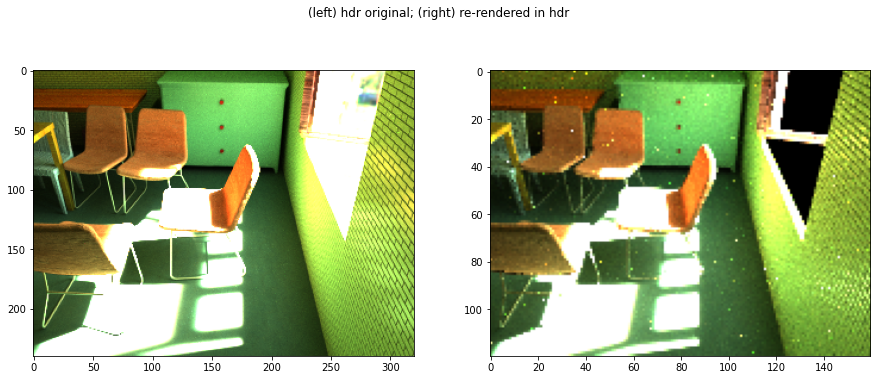

In [15]:
rL = renderingLayer(imWidth = envCol, imHeight = envRow)
diffusePred, specularPred = rL.forwardEnv(diffusePred=albedoPred.detach(), normalPred=normalPred, roughPred=roughPred, envmap=envmapsPredImage )
scale = 0.1
renderedImPred = torch.clamp(diffusePred * scale + specularPred * scale, 0, 1)
rendered_im = renderedImPred.cpu().squeeze().permute(1, 2, 0)

import matplotlib.pyplot as plt
hdr_path = root_path / meta_split / scene_name / (png_file_name.replace('.png', '.hdr'))
im = loadHdr(str(hdr_path))

fig = plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(np.clip(im * scale, 0., 1.))
plt.subplot(122)
plt.imshow(rendered_im)
fig.suptitle('(left) hdr original; (right) re-rendered in hdr')

plt.show()

## visualize depth, normal

In [16]:
print(rL.ls.shape) # hemisphere dir vector for each pixel in envmap (local coords) (8x16)
print(rL.envWeight.shape) # solid angle weight for each pixel (8x16)
print(rL.v.shape) # virtual camera plane 3D coords (x-y-z with -z forward)

torch.Size([128, 3])
torch.Size([1, 128, 1, 1, 1])
torch.Size([1, 3, 120, 160])


In [17]:
depth_path = str(root_path / meta_split / scene_name / (png_file_name.replace('im_', 'imdepth_').replace('png', 'dat'))).replace('DiffLight', '').replace('DiffMat', '')
# Read depth
depth = loadBinary(depth_path).squeeze()

f = 577.8708 / 2.
u0 = im_width / 2.
v0 = im_height / 2.

uu, vv = np.meshgrid(range(im_width), range(im_height))
z = -depth
x = - (uu - u0) / f * z
y = (vv - v0) / f * z
points = np.stack([x.squeeze(), y.squeeze(), z.squeeze()])

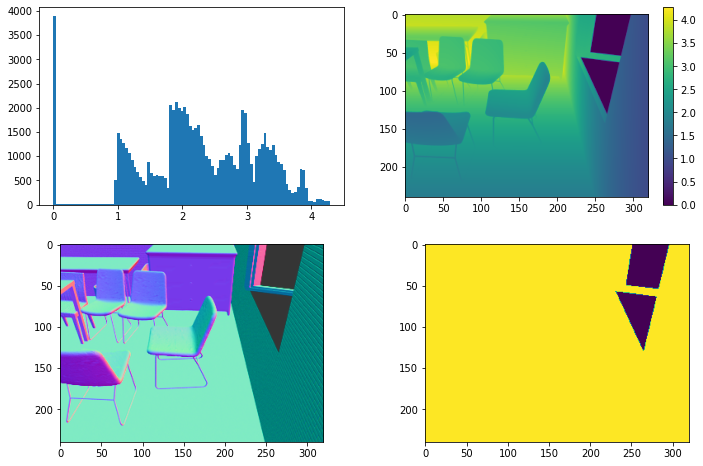

In [18]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.hist(depth.reshape(-1), 100)
plt.subplot(222)
plt.imshow(depth)
plt.colorbar()
plt.subplot(224)
mask = depth > 0.1
plt.imshow(mask)
plt.subplot(223)
normal_vis = normal.transpose(1, 2, 0)
normal_vis = (normal_vis + 1.)/2.
plt.imshow(normal_vis)
plt.show()

## visualize 3D geometry

In [19]:
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/SimpleLayout')
from SimpleLayout.utils_SL_vis import vis_cube_plt, set_axes_equal, vis_axis, vis_axis_xyz, vis_index_map

%matplotlib widget
fig = plt.figure(figsize=(15, 15))
ax_3d = fig.add_subplot(111, projection='3d')
ax_3d = fig.gca(projection='3d')
ax_3d.set_proj_type('ortho')
ax_3d.set_aspect("auto")

uu_subsample, vv_subsample = np.meshgrid(np.arange(0, im_width-1, 5), np.arange(0, im_height-1, 5))
points_subsample = points[:, vv_subsample, uu_subsample].reshape(3, -1)
# colors = points_subsample[2, :]
# colors[colors>-1.]=-1.
im_resized = cv2.resize(im, (envCol, envRow), interpolation=cv2.INTER_AREA )
im_resized = np.clip(im_resized**(1.0/2.2)/2., 0., 1.)

lightnet_downsample_ratio = im_height//im_resized.shape[0]
assert lightnet_downsample_ratio == im_width//im_resized.shape[1]

colors = im_resized[vv_subsample//lightnet_downsample_ratio, uu_subsample//lightnet_downsample_ratio, :].reshape(-1, 3)
valid_points = points_subsample[2, :] < -1.5
p = ax_3d.scatter(points_subsample[2, valid_points], points_subsample[0, valid_points], points_subsample[1, valid_points], s=12., c=colors[valid_points], cmap='jet')
# plt.colorbar(p)

vis_axis(ax_3d, make_bold=[2], tags=[r'$Z_w$', r'$X_w$', r'$Y_w$'])
# ax_3d.view_init(elev=143, azim=-63)
ax_3d.set_box_aspect([1,1,1])
xyz_min = np.amin(points_subsample, 1)
xyz_max = np.amax(points_subsample, 1)
origin = np.array([0, 0, 0])
xyz_min = np.minimum(xyz_min, origin.reshape((3,)))
xyz_max = np.maximum(xyz_max, origin.reshape((3,))+1.)

new_limits = np.hstack([xyz_min.reshape((3, 1)), xyz_max.reshape((3, 1))])
set_axes_equal(ax_3d, limits=new_limits[[2, 0, 1], :]) # IMPORTANT - this is also required
# ax_3d.axes.set_xlim3d(left=new_limits[2][0], right=new_limits[2][1])
# ax_3d.axes.set_ylim3d(bottom=new_limits[0][0], top=new_limits[0][1]) 
# ax_3d.axes.set_zlim3d(bottom=new_limits[1][0], top=new_limits[1][1])

# set_axes_equal(ax_3d) # IMPORTANT - this is also required


ax_3d.view_init(elev=20, azim=10)
# ax_3d.view_init(elev=50, azim=0)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# [2] layout_emitter + 3D lighting (mainly transform coords)

In [20]:
# borrowed from Total3D repo -> notebooks/parse_OR_labels-lighting-reindexed%2Bassigned-V4.ipynb
import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train')

import os
import json

%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib widget

# dataset = 'sunrgbd'
dataset = 'OR'

mode = 'val'
# mode = 'train'
# mode = 'train-tmp'

# split_path_dict = {'sunrgbd': 'data/sunrgbd/preprocessed', 'OR': 'utils_OR/openrooms/preprocessed-full'}
split_path_dict = {'sunrgbd': 'data/sunrgbd/preprocessed', 'OR': '/home/ruizhu/Documents/Projects/semanticInverse/train/data/openrooms/list_OR_V4full/list'}

if dataset == 'sunrgbd':
    split_file = os.path.join(split_path_dict[dataset], mode + '.json')
    with open(split_file) as file:
        split = json.load(file)
elif dataset == 'OR':
    split_file = os.path.join(split_path_dict[dataset], mode + '.txt')
    with open(split_file) as f:
        mylist = f.read().splitlines() 
    split = [x.split(' ') for x in mylist]

print(len(split), split[0])

5664 ['scene0509_00', '1', 'mainDiffLight_xml1/scene0509_00/im_1.hdr', 'main_xml1/scene0509_00/imsemLabel_1.npy']


In [21]:
import torch
import numpy as np
from pathlib import Path
from utils.utils_total3D.utils_OR_visualize import format_layout, Box
from utils.utils_total3D.data_config import OR4XCLASSES_dict, NYU40CLASSES
from utils.utils_total3D.utils_others import OR4X_mapping_catInt_to_RGB, OR4X_mapping_catStr_to_RGB
from utils.utils_total3D.utils_OR_vis_labels import read_vis_scene_3d, RGB_to_01
import pickle

OR = 'OR45'
classes = OR4XCLASSES_dict[OR] if dataset == 'OR' else NYU40CLASSES
with open(str(Path('../train/data/openrooms/total3D_colors/') / OR4X_mapping_catInt_to_RGB['light']), 'rb') as f:
    OR_mapping_catInt_to_RGB = pickle.load(f)[OR]
with open(str(Path('../train/data/openrooms/total3D_colors/') / OR4X_mapping_catStr_to_RGB['light']), 'rb') as f:
    OR_mapping_catStr_to_RGB = pickle.load(f)[OR]

import random
image_id = random.randint(0, len(split))
# image_id = 3
pickle_path_ori = split[image_id]

pickle_id = random.randint(0, len(split))
pickle_id = 18
naming = split[pickle_id][2]
# naming = 'main_xml1/scene0552_00/im_1.hdr'
# naming = 'main_xml1/scene0552_00/im_1.hdr'
# naming = 'mainDiffLight_xml1/scene0017_02/im_4.hdr'
# naming = 'mainDiffMat_xml1/scene0695_03/im_26.hdr'
# pickle_path_ori = '/data/ruizhu/OR-V3-OR45_total3D_train_test_data/%06d.pkl'%pickle_id
pickle_path_ori = '/data/ruizhu/OR-V4full-OR45_total3D_train_test_data/%s/%s/%s'%(naming.split('/')[0], naming.split('/')[1], naming.split('/')[2].replace('im', 'layout_obj').replace('hdr', 'pkl'))


grid_size = 8

pickle_path = pickle_path_ori.replace('.pkl', '_reindexed.pkl')
pickle_emitters_path = pickle_path_ori.replace('.pkl', '_emitters.pkl')
# pickle_emitters_assign_info_list_path = pickle_path_ori.replace('.pkl', '_emitters_emitters_assign_info_V2.pkl')
pickle_emitters_assign_info_list_path = pickle_path_ori.replace('.pkl', '_emitters_assign_info_%dX%d_V3.pkl'%(grid_size, grid_size))

print(pickle_path)

/data/ruizhu/OR-V4full-OR45_total3D_train_test_data/mainDiffLight_xml1/scene0552_00/layout_obj_6_reindexed.pkl


In [57]:
import pickle
with open(pickle_path, 'rb') as f:
    sequence = pickle.load(f)
print(sequence.keys())

with open(pickle_emitters_path, 'rb') as f:
    sequence_emitters = pickle.load(f)
print(sequence_emitters.keys(), sequence_emitters['sequence_name'], sequence_emitters['withinsequence_id'])
with open(pickle_emitters_assign_info_list_path, 'rb') as f:
    sequence_emitter2wall_assign_info_dict = pickle.load(f)
print(sequence_emitter2wall_assign_info_dict.keys())

%matplotlib widget

gt_boxes_list = [format_layout(x) for x in sequence['boxes']['bdb3D']]
for x, class_id in zip(gt_boxes_list, sequence['boxes']['size_cls']):
    x.update({'class_id': class_id})
gt_boxes_dict = {}
for key in list(gt_boxes_list[0].keys()):
    gt_boxes_dict[key] = [x[key] for x in gt_boxes_list]
    
# gt_layout = format_layout(sequence['layout']['bdb3D'])
gt_layout = sequence['layout']['bdb3D']

from utils.utils_total3D.data_config import Dataset_Config
from utils.utils_total3D.utils_OR_layout import to_dict_tensor

from utils.utils_total3D.utils_OR_cam import get_rotation_matrix_gt

OR = 'OR45'
dataset_config = Dataset_Config(dataset, OR=OR, version='V3', paths={'total3D_lists_path': '../train/data/openrooms/list_OR_V4full', 'layout_emitter_path': '/data/ruizhu/OR-V4full-OR45_total3D_train_test_data'})
bins_tensor = to_dict_tensor(dataset_config.bins, if_cuda=False)
cam_R_gt = get_rotation_matrix_gt(bins_tensor,
                                  torch.zeros([1]).long()+sequence['camera']['pitch_cls'], torch.zeros([1])+sequence['camera']['pitch_reg'],
                                  torch.zeros([1]).long()+sequence['camera']['roll_cls'], torch.zeros([1])+sequence['camera']['roll_reg']).squeeze().numpy()

# ======== emitters_list
emitters_obj_list = []
for x in range(sequence_emitters['boxes']['bdb3D'].shape[0]):
#     obj_dict_new = {'obj_box_3d': sequence_emitters['boxes']['bdb3D'][x], \
    obj_dict_new = {'obj_box_3d': sequence_emitters['boxes']['bdb3D_emitter_part'][x], \
                    'emitter_prop': sequence_emitters['boxes']['emitter_prop'][x], \
                    'light_world_total3d_centeraxis': sequence_emitters['boxes']['light_world_total3d_centeraxis'][x], \
                    'bdb3D_emitter_part': sequence_emitters['boxes']['bdb3D_emitter_part'][x], \
                    'cat_id': sequence_emitters['boxes']['size_cls'][x], \
                    'cat_name': classes[sequence_emitters['boxes']['size_cls'][x]], 'cat_color': RGB_to_01(OR_mapping_catInt_to_RGB[sequence_emitters['boxes']['size_cls'][x]])}
    emitters_obj_list.append(obj_dict_new)
emitter2wall_assign_info_list = sequence_emitter2wall_assign_info_dict['emitter2wall_assign_info_list']
cell_info_grid_GT_includeempty = sequence_emitter2wall_assign_info_dict['cell_info_grid']
cell_info_grid_GT = []
for wall_idx in range(6):
    for i in range(grid_size):
        for j in range(grid_size):
            cell_info = cell_info_grid_GT_includeempty[wall_idx * grid_size**2 + i * grid_size + j]
            if cell_info['obj_type'] is not None:
                cell_info['wallidx_i_j'] = (wall_idx, i, j)
                cell_info_grid_GT.append(cell_info)


plt.figure(figsize=(15, 8))
ax_2d = plt.gca()

# grid_prob = sequence_emitter2wall_assign_info_dict['cell_prob_mean'].reshape(6, -1)
grid_prob = sequence_emitter2wall_assign_info_dict['wall_grid_prob'].reshape(6, -1)
import imageio
rgb_img = imageio.imread(sequence['rgb_img_path'])

scene_box = Box(rgb_img, None, sequence['camera']['K'], cam_R_gt, None, gt_layout, None, gt_boxes_dict, None, 'GT', None, dataset=dataset, OR='OR45', \
                emitters_obj_list=emitters_obj_list, emitter2wall_assign_info_list=emitter2wall_assign_info_list, \
                emitter_cls_prob_PRED=np.random.random((6, grid_size**2)), emitter_cls_prob_GT=grid_prob, cell_info_grid_GT=cell_info_grid_GT, grid_size=grid_size, \
                paths={'color_file': '../train/data/openrooms/total3D_colors/OR4X_mapping_catInt_to_RGB_light.pkl'})
if_use_plt=True
img_map, _ = scene_box.draw_projected_layout('GT', return_plt=True, if_save=False, save_path='', if_use_plt=if_use_plt, fig_or_ax=ax_2d)
img_map2 = scene_box.draw_projected_bdb3d('GT', return_plt=True, if_save=False, save_path='', if_use_plt=if_use_plt, fig_or_ax=ax_2d)
# plt.show()

fig_3d, ax_3ds_scene = scene_box.draw_3D_scene_plt('GT', if_show_objs=False)
# ax_3d = ax_3ds[0]
# ax_3d[0].view_init(elev=-46, azim=86)

# %matplotlib widget
# sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train/SimpleLayout')
# depth_combined, mask_conflict = scene_box.draw_projected_depth('GT', return_plt=True, if_save=False, save_path='', if_vis=True)


dict_keys(['transform_R', 'transform_t', 'rgb_img_path', 'envmap_info', 'depth_map', 'boxes', 'camera', 'layout', 'scene_name', 'withinsequence_id', 'meta_split', 'meta_name', 'sub_name', 'scene_pickle_file', 'cam_pickle_file', 'frame_pickle_file', 'reindex_info_dict'])
dict_keys(['sequence_name', 'withinsequence_id', 'boxes']) scene0552_00 6
dict_keys(['emitter2wall_assign_info_list', 'emitters_obj_list', 'wall_grid_prob', 'cell_prob_mean', 'cell_prob', 'cell_count', 'cell_info_grid'])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[draw_projected_layout] Returned.
[draw_projected_bdb3d] Returned.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## parallize acquisition of cell params

In [23]:
# torch
basis_v_indexes = [(3, 2, 0), (7, 4, 6), (4, 0, 5), (6, 5, 2), (7, 6, 3), (7, 3, 4)]

layout_cuda = torch.from_numpy(gt_layout).cuda()
origin_v1_v2_list = [basis_v_indexes[wall_idx] for wall_idx in range(6)]
basis_1_list = [(layout_cuda[origin_v1_v2[1]] - layout_cuda[origin_v1_v2[0]]) / grid_size for origin_v1_v2 in origin_v1_v2_list]
basis_2_list = [(layout_cuda[origin_v1_v2[2]] - layout_cuda[origin_v1_v2[0]]) / grid_size for origin_v1_v2 in origin_v1_v2_list]
origin_0_list = [layout_cuda[origin_v1_v2[0]] for origin_v1_v2 in origin_v1_v2_list]

basis_1_array = torch.stack(basis_1_list).unsqueeze(1).unsqueeze(1).float() # torch.Size([6, 1, 1, 3])
basis_2_array = torch.stack(basis_2_list).unsqueeze(1).unsqueeze(1).float()
origin_0_array = torch.stack(origin_0_list).unsqueeze(1).unsqueeze(1).float()

ii, jj = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
ii, jj = ii.cuda().unsqueeze(0).unsqueeze(-1).float(), jj.cuda().unsqueeze(0).unsqueeze(-1).float()
x_ij = basis_1_array * ii + basis_2_array * jj + origin_0_array
x_i1j = basis_1_array * (ii+1.) + basis_2_array * jj + origin_0_array
x_i1j1 = basis_1_array * (ii+1.) + basis_2_array * (jj+1.) + origin_0_array
x_ij1 = basis_1_array * ii + basis_2_array * (jj+1.)+ origin_0_array
verts_all = torch.stack([x_ij, x_i1j, x_i1j1, x_ij1], -1).transpose(-1, -2) # torch.Size([6, 8, 8, 4, 3])
verts_flattened = verts_all.reshape(-1, 4, 3).transpose(-1, -2) # torch.Size([?, 3, 4])

extra_transform_matrix = torch.tensor([[0., 0., 1.], [0., -1., 0.], [1., 0., 0.]]).unsqueeze(0).cuda().float()
cam_R_transform, cam_t_transform = torch.from_numpy(cam_R_gt.T).cuda().float().unsqueeze(0), torch.zeros((1, 3, 1)).cuda().float()
nverts = verts_flattened.shape[0]
x1x2_transformed = cam_R_transform.expand(nverts, -1, -1) @ verts_flattened + cam_t_transform
x1x2_transformed = x1x2_transformed.transpose(-1, -2) @ extra_transform_matrix.expand(nverts, -1, -1) # camera projection coords: z forward, x right, y down
extra_transform_matrix_LightNet = torch.tensor([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]]).unsqueeze(0).cuda().float()
x1x2_transformed_LightNet = x1x2_transformed @ extra_transform_matrix_LightNet.expand(nverts, -1, -1) # LightNet coords: z backward, x right, y up # [1536, 1, 3]

verts_transformed_LightNet = torch.squeeze(x1x2_transformed_LightNet, 1).reshape(6, grid_size, grid_size, 4, 3)
verts_center_transformed_LightNet = torch.mean(verts_transformed_LightNet, 3) # torch.Size([6, 8, 8, 3])

verts_center = torch.mean(verts_all, 3) # torch.Size([6, 8, 8, 3])
x_ij.shape
wall_idx = 2
i = 4
j = 5
# print(tmp_list[wall_idx * grid_size**2 + i * grid_size + j])
print(verts_all[wall_idx, i, j])

extra_transform_matrix = np.array([[0., 0., 1.], [0., -1., 0.], [1., 0., 0.]])
cam_R_transform, cam_t_transform = cam_R_gt.T, np.zeros((3, 1))
extra_transform_matrix_LightNet = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])
x1x2_transformed = (cam_R_transform @ verts_center[wall_idx, i, j].reshape(3, 1).cpu().numpy() + cam_t_transform).T @ extra_transform_matrix # camera projection coords: z forward, x right, y down
extra_transform_matrix_LightNet = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])
x1x2_transformed_LightNet = x1x2_transformed @ extra_transform_matrix_LightNet # LightNet coords: z backward, x right, y up
print(x1x2_transformed_LightNet)
print(verts_center_transformed_LightNet[wall_idx, i, j])

tensor([[ 1.2688, -0.1034, -5.1107],
        [ 1.2688,  0.2716, -5.1107],
        [ 0.6891,  0.2716, -5.1287],
        [ 0.6891, -0.1034, -5.1287]], device='cuda:0')
[[-5.1194  0.6006 -0.7795]]
tensor([-5.1194,  0.6006, -0.7795], device='cuda:0')


# [3] class decoder_emitter_lightAccu(nn.Module)

In [24]:
B = 2
depth_torch = torch.from_numpy(depth).cuda().float().unsqueeze(0).repeat(B, 1, 1).contiguous() # (B, 240, 320)
normal_torch = torch.from_numpy(normal).cuda().float().unsqueeze(0).repeat(B, 1, 1, 1).contiguous() # (B, 3, 240, 320)
envmaps_torch = torch.from_numpy(envmaps).cuda().float().unsqueeze(0).repeat(B, 1, 1, 1, 1, 1).contiguous() # (B, 3, 120, 160, 8, 16)
cam_K_torch = torch.from_numpy(sequence['camera']['K']).cuda().float().unsqueeze(0).repeat(B, 1, 1).contiguous()
layout_torch = torch.from_numpy(gt_layout).cuda().float().unsqueeze(0).repeat(B, 1, 1).contiguous()
cam_R_gt_torch = torch.from_numpy(cam_R_gt).cuda().float().unsqueeze(0).repeat(B, 1, 1).contiguous()

input_dict = {'normalPred_lightAccu':normal_torch, 'depthPred_lightAccu': depth_torch, 'envmapsPredImage_lightAccu': envmaps_torch, 'cam_K': cam_K_torch, 'cam_R': cam_R_gt_torch, 'layout': layout_torch}
output_path = '/home/ruizhu/Downloads/tmp.pickle'

with open(str(output_path),"wb") as f:
    pickle.dump(input_dict, f)


In [14]:
output_path = '/home/ruizhu/Downloads/tmp.pickle'
import pickle
with open(output_path, 'rb') as f:
    input_dict = pickle.load(f)

In [54]:
import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train')
import torch
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from models_def.models_layout_emitter_lightAccu import emitter_lightAccu

lightAccuNet = emitter_lightAccu(params={'im_width': 320, 'im_height': 240})

return_dict = lightAccuNet(input_dict) # 1.4Gi, [2, 3, 384, 120, 160]) [2, 384, 3]
# print(X.shape, envmap_vis_mean_.shape)
envmap_vis_ = return_dict['envmap_lightAccu']
envmap_vis_mean_ = return_dict['envmap_lightAccu_mean']
color_array_full = torch.clip(0.1 * return_dict['envmap_lightAccu_mean']**(1.0/2.2), 0., 1.).cpu().numpy()[0]
print(color_array_full.shape)

(384, 3)


In [50]:
a = return_dict['envmap_lightAccu_mean']**(1.0/2.2)
print(torch.max(a))

tensor(17.4994, device='cuda:0')


# [4] vis: all cell patches (colored by accumulated light)

In [45]:
%reload_ext autoreload
%autoreload 2

from models_def.models_layout_emitter_lightAccu import emitter_lightAccu

lightAccuNet = emitter_lightAccu(params={'im_width': 320, 'im_height': 240})
return_dict = lightAccuNet(input_dict) # 1.4Gi, [2, 3, 384, 120, 160]) [2, 384, 3]

# verts_center_transformed_LightNet = return_dict['verts_center_transformed_LightNet'][0].cpu().numpy()
verts_transformed_LightNet = return_dict['verts_transformed_LightNet'][0].cpu().numpy()
basis_1_array_transformed_LightNet = return_dict['basis_1_array_transformed_LightNet'][0].cpu().numpy()
basis_2_array_transformed_LightNet = return_dict['basis_2_array_transformed_LightNet'][0].cpu().numpy()
origin_0_array_transformed_LightNet = return_dict['origin_0_array_transformed_LightNet'][0].cpu().numpy()
normal_inside_array_transformed_LightNet = return_dict['normal_array_transformed_LightNet'][0].cpu().numpy()

In [48]:
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/SimpleLayout')
from SimpleLayout.utils_SL_vis import vis_cube_plt, set_axes_equal, vis_axis, vis_axis_xyz, vis_index_map

%matplotlib widget
fig = plt.figure(figsize=(15, 15))
# fig = plt.figure(figsize=(8, 8))
ax_3d = fig.add_subplot(111, projection='3d')
ax_3d = fig.gca(projection='3d')
ax_3d.set_proj_type('ortho')
ax_3d.set_aspect("auto")

uu_subsample, vv_subsample = np.meshgrid(np.arange(0, im_width-1, 5), np.arange(0, im_height-1, 5))
points_subsample = points[:, vv_subsample, uu_subsample].reshape(3, -1)
# colors = points_subsample[2, :]
# colors[colors>-1.]=-1.
im_resized = cv2.resize(im, (envCol, envRow), interpolation=cv2.INTER_AREA )
im_resized = np.clip((0.3*im_resized)**(1.0/2.2)/2., 0., 1.)

lightnet_downsample_ratio = im_height//im_resized.shape[0]
assert lightnet_downsample_ratio == im_width//im_resized.shape[1]

colors = im_resized[vv_subsample//lightnet_downsample_ratio, uu_subsample//lightnet_downsample_ratio, :].reshape(-1, 3)
valid_points = points_subsample[2, :] < -1.5
p = ax_3d.scatter(points_subsample[2, valid_points], points_subsample[0, valid_points], points_subsample[1, valid_points], s=12., c=colors[valid_points], cmap='jet')


vis_axis(ax_3d, make_bold=[2], tags=[r'$Z_w$', r'$X_w$', r'$Y_w$'])
# ax_3d.view_init(elev=143, azim=-63)
ax_3d.set_box_aspect([1,1,1])
xyz_min = np.amin(points_subsample, 1)
xyz_max = np.amax(points_subsample, 1)
origin = np.array([0, 0, 0])
xyz_min = np.minimum(xyz_min, origin.reshape((3,)))
xyz_max = np.maximum(xyz_max, origin.reshape((3,))+1.)

new_limits = np.hstack([xyz_min.reshape((3, 1)), xyz_max.reshape((3, 1))])
set_axes_equal(ax_3d, limits=new_limits[[2, 0, 1], :]) # IMPORTANT - this is also required
# ax_3d.axes.set_xlim3d(left=new_limits[2][0], right=new_limits[2][1])
# ax_3d.axes.set_ylim3d(bottom=new_limits[0][0], top=new_limits[0][1]) 
# ax_3d.axes.set_zlim3d(bottom=new_limits[1][0], top=new_limits[1][1])

# set_axes_equal(ax_3d) # IMPORTANT - this is also required


# ax_3d.view_init(elev=10, azim=10)
ax_3d.view_init(elev=-2, azim=-33)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [36]:
normal_inside_single = return_dict['normal_array_transformed_LightNet'][0, wall_idx, :].cpu().numpy()
basis_1_single = return_dict['basis_1_array_transformed_LightNet'][0, wall_idx, :].cpu().numpy()
basis_2_single = return_dict['basis_2_array_transformed_LightNet'][0, wall_idx, :].cpu().numpy()

from SimpleLayout.utils_SL_vis import Arrow3D

a = Arrow3D([origin_0[2], (origin_0+basis_1_single)[2]], [origin_0[0], (origin_0+basis_1_single)[0]], [origin_0[1], (origin_0+basis_1_single)[1]], mutation_scale=20,
lw=0.5, arrowstyle="Fancy", facecolor='r')
ax_3d.add_artist(a)
a = Arrow3D([origin_0[2], (origin_0+basis_2_single)[2]], [origin_0[0], (origin_0+basis_2_single)[0]], [origin_0[1], (origin_0+basis_2_single)[1]], mutation_scale=20,
lw=0.5, arrowstyle="Fancy", facecolor='g')
ax_3d.add_artist(a)
a = Arrow3D([origin_0[2], (origin_0+normal_inside_single)[2]], [origin_0[0], (origin_0+normal_inside_single)[0]], [origin_0[1], (origin_0+normal_inside_single)[1]], mutation_scale=20,
lw=0.5, arrowstyle="Fancy", facecolor='b')
ax_3d.add_artist(a)


scattered_light, emitter_global2localLightNet_trans_matrix = lightAccuNet.scatter_light_to_hemisphere(return_dict)
emitter_outdirs_meshgrid_global_transformed_LightNet = lightAccuNet.get_emitter_outdirs_meshgrid(emitter_global2localLightNet_trans_matrix)

tmp_global2local = emitter_global2localLightNet_trans_matrix[0, cell_idx, :].squeeze().cpu().numpy()
print(tmp_global2local @ (normal_inside_single.reshape(3,1))) # should be [0, 0, 1]
z_local = np.array([0., 0., 1.]).reshape(3, 1)
print(tmp_global2local.T @ (z_local.reshape(3,1)), normal_inside_single) # should be z_global

emitter_outdirs_meshgrid = emitter_outdirs_meshgrid_global_transformed_LightNet.cpu().numpy()[0][cell_idx]

z_global = emitter_global2localLightNet_trans_matrix[0, cell_idx, :].squeeze().cpu().numpy() @ z_local

for i in range(0, 8):
    for j in range(0, 16):
        ls_global = emitter_outdirs_meshgrid[i, j, :]
        ls_global = ls_global / np.linalg.norm(ls_global)

#         a = Arrow3D([origin_0[2], origin_0[2]+ls_local[2]], [origin_0[0], origin_0[0]+ls_local[0]], [origin_0[1], origin_0[1]+ls_local[1]], mutation_scale=20,
#             lw=1, arrowstyle="->", color='k')
#         ax_3d.add_artist(a)
        ax_3d.scatter3D(origin_0[2]+ls_global[2], origin_0[0]+ls_global[0], origin_0[1]+ls_global[1], color='k', s = 100)

NameError: name 'origin_0' is not defined

In [141]:
# LOCAL hemishpere coords at an emitter
ls_coords_local = lightAccuNet.rL.ls.cpu().numpy().reshape(8, 16, 3)

%matplotlib widget
fig = plt.figure(figsize=(5, 5))
ax_3d_local = fig.add_subplot(111, projection='3d')
ax_3d_local = fig.gca(projection='3d')
ax_3d_local.set_proj_type('ortho')
ax_3d_local.set_aspect("auto")
vis_axis(ax_3d_local, make_bold=[2], tags=[r'$Z_w$', r'$X_w$', r'$Y_w$'])

for ls_local in ls_coords_local.reshape(-1, 3):
    ls_local = ls_local * 0.5
    a = Arrow3D([0., ls_local[2]], [0., ls_local[0]], [0., ls_local[1]], mutation_scale=20,
        lw=1, arrowstyle="->", color='k')
    ax_3d_local.add_artist(a)

ax_3d_local.set_box_aspect([1,1,1])
set_axes_equal(ax_3d_local, limits=np.array([[-1., 1.], [-1., 1.], [-1., 1.]])) # IMPORTANT - this is also required
ax_3d_local.view_init(elev=-34, azim=43)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## ADD vis: sample lights for ONE cell

In [37]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

rL = renderingLayer(imWidth = envCol, imHeight = envRow)
ls_coords, camx, camy, normalPred = rL.forwardEnv(normalPred, envmapsPredImage, if_normal_only=True) # torch.Size([B(1), 128, 3, 120, 160]), [B(1), 3, 120, 160], [B(1), 3, 120, 160], [B(1), 3, 120, 160]
envmapWidth = envCol
envmapHeight = envRow
vv, uu = torch.meshgrid(torch.arange(envmapHeight), torch.arange(envmapWidth))
uu, vv = uu.cuda(), vv.cuda()

points_torch = torch.from_numpy(points).cuda().float().unsqueeze(0) # (1, 3, 240, 320)


p_t_all_grids = return_dict['verts_center_transformed_LightNet'][0].view(-1, 3).unsqueeze(0) # torch.Size([B(1), #grids, 3])
ngrids = p_t_all_grids.shape[-2]
p_t_all_grids = p_t_all_grids.unsqueeze(2).unsqueeze(3) # torch.Size([B(1), #grids, 1, 1, 3])

lightnet_downsample_ratio = im_height//im_resized.shape[0]
assert lightnet_downsample_ratio == im_width//im_resized.shape[1]

points_sampled = points_torch[:, :, vv*lightnet_downsample_ratio, uu*lightnet_downsample_ratio].permute(0, 2, 3, 1) # [B(1), 120, 160, 3]
points_sampled_mask = points_sampled[:, :, :, -1] < -0.1
points_sampled = points_sampled.unsqueeze(1) # torch.Size([B(1), 1, 120, 160, 3])

In [49]:
from SimpleLayout.utils_SL_vis import Arrow3D

wall_idx, cell_i, cell_j = 5, 3, 4 # window
cell_idx = wall_idx * grid_size**2 + cell_i * grid_size + cell_j
p_t_one = p_t_all_grids[:, cell_idx, :, :, :].squeeze().cpu().numpy()

envmap_vis_one = envmap_vis_.cpu().numpy()[0, :, cell_idx, :, :].squeeze().transpose(1, 2, 0)
envmap_vis_one = envmap_vis_one**(1./2.2)
envmap_vis_one = envmap_vis_one * 0.4 # TODO
envmap_vis_one = np.clip(envmap_vis_one, 0., 1.)
points_sampled_one = points_sampled.cpu().numpy().squeeze()

for i in np.arange(0, envRow, 20):
    for j in np.arange(0, envCol, 20):
        p_one = points_sampled_one[i, j, :].flatten()
        p = ax_3d.scatter(p_one[2], p_one[0], p_one[1], s=20., c='k', cmap='jet')
        
        face_color = envmap_vis_one[i, j, :].flatten().tolist()
        
#         az = phi_SG[i, j].item()/np.pi*180.
#         az_color = np.clip((az + 180.)/360., 0., 1.)
#         face_color = [az_color, az_color, az_color] # brighter, bigger value
#         el = 90.-theta_SG[i, j].item()/np.pi*180.
#         el_color = np.clip(el/90., 0., 1.)
#         face_color = [el_color, el_color, el_color] # brighter, bigger value

       
        a = Arrow3D([p_one[2], p_t_one[2]], [p_one[0], p_t_one[0]], [p_one[1], p_t_one[1]], mutation_scale=20,
            lw=0.5, arrowstyle="Simple", facecolor=face_color)
        ax_3d.add_artist(a)

verts = verts_transformed_LightNet[wall_idx, cell_i, cell_j, :, :].squeeze()
verts_zup = np.hstack([verts[:, 2:3], verts[:, 0:1], verts[:, 1:2]])
verts_zup_list = [(verts_zup).tolist()]

color_array = np.clip(envmap_vis_mean_.cpu().numpy().squeeze()[0], 0., 1.)
# color_array = envmap_vis_max_.cpu().numpy().squeeze()
face_color = color_array[cell_idx]
poly = Poly3DCollection(verts_zup_list, facecolor=face_color.tolist(), edgecolor=[1., 1., 1.])
poly.set_alpha(0.8)
ax_3d.add_collection3d(poly)

# origin_0 = origin_0_array_transformed_LightNet[wall_idx]
origin_0 = verts.mean(0)
basis_1 = basis_1_array_transformed_LightNet[wall_idx]
basis_2 = basis_2_array_transformed_LightNet[wall_idx]
normal_inside = normal_inside_array_transformed_LightNet[wall_idx]
a = Arrow3D([origin_0[2], (origin_0+basis_1)[2]], [origin_0[0], (origin_0+basis_1)[0]], [origin_0[1], (origin_0+basis_1)[1]], mutation_scale=20,
lw=0.5, arrowstyle="Fancy", facecolor='r')
ax_3d.add_artist(a)
a = Arrow3D([origin_0[2], (origin_0+basis_2)[2]], [origin_0[0], (origin_0+basis_2)[0]], [origin_0[1], (origin_0+basis_2)[1]], mutation_scale=20,
lw=0.5, arrowstyle="Fancy", facecolor='g')
ax_3d.add_artist(a)
a = Arrow3D([origin_0[2], (origin_0+normal_inside)[2]], [origin_0[0], (origin_0+normal_inside)[0]], [origin_0[1], (origin_0+normal_inside)[1]], mutation_scale=20,
lw=0.5, arrowstyle="Fancy", facecolor='b')
ax_3d.add_artist(a)

### sampled lights -> pixels on emitter hemisphere -> visualize

In [41]:
# emitter_out_dirs_emitter_local = emitter_out_dirs[:, :, 0:1] * emitter_local_x + emitter_out_dirs[:, :, 1:2] * emitter_local_y + emitter_out_dirs[:, :, 2:3] * emitter_local_z # outgoing dirs in emitter-local coords
emitter_out_dirs = torch.from_numpy(points_sampled_one - p_t_one.reshape((1, 1, 3))).cuda() # (120, 160, 3)
emitter_local_x = torch.from_numpy(basis_1.reshape(1, 1, 3)).cuda()
emitter_local_y = torch.from_numpy(basis_2.reshape(1, 1, 3)).cuda()
emitter_local_z = torch.from_numpy(normal_inside.reshape(1, 1, 3)).cuda()
emitter_local_xyz_trans = torch.stack([emitter_local_x, emitter_local_y, emitter_local_z], -1).transpose(-1, -2) # emitter local coords -> LightNet global coords
emitter_out_dirs_emitter_local = (emitter_local_xyz_trans @ emitter_out_dirs.unsqueeze(-1)).squeeze(-1)
# print(emitter_out_dirs_emitter_local.shape)
# print((emitter_local_xyz_trans @ torch.from_numpy(normal_inside.reshape(1, 1, 3, 1)).cuda()).cpu().numpy().flatten()) # should get [0., 0., 1.]

envmap_vis_one_torch = torch.from_numpy(envmap_vis_one).cuda()

envWidth = 16
envHeight = 8
# envWidth = 64
# envHeight = 32

# l_local -> pixel coords in envmap
cos_theta = emitter_out_dirs_emitter_local[:, :, 2]
theta_SG = torch.arccos(cos_theta) # [0, pi] # 90-el
cos_phi = emitter_out_dirs_emitter_local[:, :, 0] / (torch.sin(theta_SG)+1e-6)
sin_phi = emitter_out_dirs_emitter_local[:, :, 1] / (torch.sin(theta_SG)+1e-6)
phi_SG = torch.atan2(sin_phi, cos_phi) # az
# assert phi_SG >= -np.pi and phi_SG <= np.pi

az_pix = (phi_SG / np.pi / 2. + 0.5) * envWidth - 0.5 # [120, 160]
valid_mask_az = torch.logical_not(torch.isnan(az_pix))
valid_mask = torch.logical_and(torch.logical_and(az_pix>-0.5, az_pix<(envWidth-1.+0.5)), valid_mask_az)
el_pix = theta_SG / np.pi * 2. * envHeight - 0.5 # [120, 160]
valid_mask_el = torch.logical_not(torch.isnan(el_pix))
valid_mask = torch.logical_and(torch.logical_and(el_pix>0.5, el_pix<(envHeight-1.+0.5)), valid_mask_el)


scattered_light_single = torch.zeros(envHeight, envWidth, 3).cuda()
valid_uu = torch.round(az_pix).long()[valid_mask]
valid_vv = torch.round(el_pix).long()[valid_mask]
scattered_light_single[valid_vv, valid_uu, :] = envmap_vis_one_torch[valid_mask]
print(valid_mask.shape, valid_uu.shape, scattered_light_single[valid_vv, valid_uu, :].shape) # torch.Size([120, 160]) torch.Size([13388]) torch.Size([13388, 3])

plt.figure(figsize=(10, 2))
ax = plt.subplot(131)
plt.imshow((scattered_light_single**(1./2.2)).cpu().numpy())
ax.set_title('left-right: azimuth, down-up: elevation')
ax = plt.subplot(132)
plt.hist(90.-theta_SG[valid_mask].cpu().numpy() / np.pi * 180., 100)
ax.set_title('elevation angle in degrees')
ax = plt.subplot(133)
plt.hist(phi_SG[valid_mask].cpu().numpy() / np.pi * 180., 100)
ax.set_title('azimuth angle in degrees')
plt.show()

torch.Size([120, 160]) torch.Size([3464]) torch.Size([3464, 3])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### vis local hemisphere of the emitter & direct lighting map

In [42]:
origin_0 = verts.mean(0)
for i in range(0, 120, 20):
    for j in range(0, 160, 20):
        ls_local = emitter_out_dirs.cpu().numpy()[i, j, :]
        ls_local = ls_local / np.linalg.norm(ls_local)

        a = Arrow3D([origin_0[2], origin_0[2]+ls_local[2]], [origin_0[0], origin_0[0]+ls_local[0]], [origin_0[1], origin_0[1]+ls_local[1]], mutation_scale=20,
            lw=1, arrowstyle="->", color='k')
        ax_3d.add_artist(a)

In [43]:
plt.figure()
plt.imshow(envmap_vis_one)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [66]:
%matplotlib widget
fig = plt.figure(figsize=(5, 5))
ax_3d_local = fig.add_subplot(111, projection='3d')
ax_3d_local = fig.gca(projection='3d')
ax_3d_local.set_proj_type('ortho')
ax_3d_local.set_aspect("auto")
ax_3d_local.set_title('z up')
vis_axis(ax_3d_local, make_bold=[2], tags=[r'$X_w$', r'$Y_w$', r'$Z_w$'])

# for ls_local in emitter_ls.cpu().numpy():
#     ls_local = ls_local * 5. # scaling for vis purposes
for i in range(0, 120, 20):
    for j in range(0, 160, 20):
        ls_local = emitter_out_dirs_emitter_local.cpu().numpy()[i, j, :]
        az = phi_SG[i, j].item()/np.pi*180.
        el = 90.-theta_SG[i, j].item()/np.pi*180.
        print(az, el)
        
#         color = [np.clip(el/90., 0., 1.), np.clip(el/90., 0., 1.), np.clip(el/90., 0., 1.)] # brighter, bigger value
        az_color = np.clip((az + 180.)/360., 0., 1.)
        color = [az_color, az_color, az_color] # brighter, bigger value

#         color = [1., 1., 1.]
        a = Arrow3D([0, ls_local[0]], [0, ls_local[1]], [0, ls_local[2]], mutation_scale=20,
            lw=1, arrowstyle="->", color=color)
        ax_3d_local.add_artist(a)
    
ax_3d_local.set_box_aspect([1,1,1])
set_axes_equal(ax_3d_local, limits=np.array([[-1., 1.], [-1., 1.], [-1., 1.]])) # IMPORTANT - this is also required
ax_3d_local.view_init(elev=0, azim=0)
# k = torch.from_numpy(basis_1).cuda().reshape(1, 1, 3, 1)
# emitter_local_xyz_trans @ k

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

nan nan
nan nan
nan nan
nan nan
nan nan
56.70803831990814 4.496208573303676
42.50807162035704 0.696212337999583
17.677521656969944 1.1019460652658353
nan nan
nan nan
nan nan
nan nan
nan nan
74.80804303553651 2.233694750358609
63.90088662918647 0.7326240764649157
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
98.07643482064063 0.3159415559591139
101.75508591515026 0.762021210652648
111.79458290066609 -41.06340715310748
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
135.80034824818642 0.8057275911515518
-175.21485643871546 30.39357432089153
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
-170.4038897534119 45.547523787102065
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


## ADD vis: all cell patches (colored by accumulated light)

In [52]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

print(color_array_full.shape)

layout = gt_layout

extra_transform_matrix = np.array([[0., 0., 1.], [0., -1., 0.], [1., 0., 0.]])
cam_R_transform, cam_t_transform = cam_R_gt.T, np.zeros((3, 1))
extra_transform_matrix_LightNet = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])

# basis_v_indexes = [(3, 2, 0), (7, 6, 4), (4, 5, 0), (6, 2, 5), (7, 6, 3), (7, 3, 4)]
basis_v_indexes = [(3, 2, 0), (7, 4, 6), (4, 0, 5), (6, 5, 2), (7, 6, 3), (7, 3, 4)]
tmp_list = []
for wall_idx in range(6):
#     if wall_idx != 2:
#         continue
    origin_v1_v2 = basis_v_indexes[wall_idx]
    basis_1 = (layout[origin_v1_v2[1]] - layout[origin_v1_v2[0]]) / grid_size
    basis_2 = (layout[origin_v1_v2[2]] - layout[origin_v1_v2[0]]) / grid_size
    origin_0 = layout[origin_v1_v2[0]]

    for i in range(grid_size):
        for j in range(grid_size):
            x_ij = basis_1 * i + basis_2 * j + origin_0
            x_i1j = basis_1 * (i+1) + basis_2 * j + origin_0
            x_i1j1 = basis_1 * (i+1) + basis_2 * (j+1) + origin_0
            x_ij1 = basis_1 * i + basis_2 * (j+1) + origin_0
            verts = [[list(x_ij), list(x_i1j), list(x_i1j1), list(x_ij1)]]
            verts_array = np.asarray(verts).squeeze()
            tmp_list.append(verts_array)

            verts_array_centter = np.mean(verts_array, 0)[:, np.newaxis]
            
            x1x2_transformed = (cam_R_transform @ verts_array.T + cam_t_transform).T @ extra_transform_matrix # camera projection coords: z forward, x right, y down
            extra_transform_matrix_LightNet = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])
            x1x2_transformed_LightNet = x1x2_transformed @ extra_transform_matrix_LightNet # LightNet coords: z backward, x right, y up
            x1x2_transformed_LightNet_zup = np.hstack([x1x2_transformed_LightNet[:, 2:3], x1x2_transformed_LightNet[:, 0:1], x1x2_transformed_LightNet[:, 1:2]]) # for vis purpose only
            
            verts = [(x1x2_transformed_LightNet_zup).tolist()]
            
            cell_idx = wall_idx * grid_size**2 + i * grid_size + j
            face_color = color_array_full[cell_idx]
#             poly = Poly3DCollection(verts, facecolor=[1., 0., 0.], edgecolor=[1., 1., 1.])
            poly = Poly3DCollection(verts, facecolor=face_color.tolist(), edgecolor=[1., 1., 1.])
#             poly.set_alpha(0.2)
            poly.set_alpha(0.8)
            ax_3d.add_collection3d(poly)



(384, 3)


In [56]:
grid_size = 8
color_array_GT = color_array_full.reshape(6, grid_size, grid_size, -1)

%matplotlib widget

scene_box = Box(rgb_img, None, sequence['camera']['K'], cam_R_gt, None, gt_layout, None, gt_boxes_dict, None, 'GT', None, dataset=dataset, OR='OR45', \
                emitters_obj_list=emitters_obj_list, emitter2wall_assign_info_list=emitter2wall_assign_info_list, \
                emitter_cls_prob_PRED=np.random.random((6, grid_size**2)), emitter_cls_prob_GT=grid_prob, cell_info_grid_GT=cell_info_grid_GT, grid_size=grid_size, \
                paths={'color_file': '../train/data/openrooms/total3D_colors/OR4X_mapping_catInt_to_RGB_light.pkl'})

fig_3d, ax_3d = scene_box.draw_3D_scene_plt('GT', )
ax_3d[1] = fig_3d.add_subplot(122, projection='3d')
scene_box.draw_3D_scene_plt('GT', fig_or_ax=[ax_3d[1], ax_3d[0]], hide_cells=True)

scene_box.draw_all_cells(ax_3d[1], gt_layout, lightnet_array_GT=color_array_GT, alpha=1.)

# az = 92
# elev = 113
# ax_3d[1].view_init(elev=elev, azim=az)
# ax_3d[0].view_init(elev=elev, azim=az)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### using output from AccuNet

all cells:

In [40]:
%reload_ext autoreload
%autoreload 2

from models_def.models_layout_emitter_lightAccu import emitter_lightAccu

lightAccuNet = emitter_lightAccu(params={'im_width': 320, 'im_height': 240})
return_dict = lightAccuNet(input_dict) # 1.4Gi, [2, 3, 384, 120, 160]) [2, 384, 3]

verts_center_transformed_LightNet = return_dict['verts_center_transformed_LightNet'][0].cpu().numpy()
verts_transformed_LightNet = return_dict['verts_transformed_LightNet'][0].cpu().numpy()
basis_1_array_transformed_LightNet = return_dict['basis_1_array_transformed_LightNet'][0].cpu().numpy()
basis_2_array_transformed_LightNet = return_dict['basis_2_array_transformed_LightNet'][0].cpu().numpy()
origin_0_array_transformed_LightNet = return_dict['origin_0_array_transformed_LightNet'][0].cpu().numpy()

for wall_idx in range(6):
    basis_1 = basis_1_array_transformed_LightNet[wall_idx]
    basis_1 = basis_1 / np.linalg.norm(basis_1)
    basis_2 = basis_2_array_transformed_LightNet[wall_idx]
    basis_2 = basis_2 / np.linalg.norm(basis_2)
    origin_0 = origin_0_array_transformed_LightNet[wall_idx]
#     print(wall_idx, basis_1, basis_2)
    normal_inside = np.cross(basis_1, basis_2)

    for i in range(grid_size):
        for j in range(grid_size):
            x1x2_transformed_LightNet = verts_transformed_LightNet[wall_idx][i][j]
            x1x2_transformed_LightNet_zup = np.hstack([x1x2_transformed_LightNet[:, 2:3], x1x2_transformed_LightNet[:, 0:1], x1x2_transformed_LightNet[:, 1:2]]) # for vis purpose only
            
            verts = [(x1x2_transformed_LightNet_zup).tolist()]
            
            cell_idx = wall_idx * grid_size**2 + i * grid_size + j
            
            face_color = color_array_full[cell_idx]
            poly = Poly3DCollection(verts, facecolor=face_color.tolist(), edgecolor=[1., 1., 1.])
#             poly.set_alpha(0.8)
            poly.set_alpha(0.2)
            ax_3d.add_collection3d(poly)

#     origin_0 = x1x2_transformed_LightNet_zup.mean(0)

#     if wall_idx == 2:
#         a = Arrow3D([origin_0[2], (origin_0+basis_1*(wall_idx+1))[2]], [origin_0[0], (origin_0+basis_1*(wall_idx+1))[0]], [origin_0[1], (origin_0+basis_1*(wall_idx+1))[1]], mutation_scale=20,
#         lw=0.5, arrowstyle="Fancy", facecolor='r')
#         ax_3d.add_artist(a)
#         a = Arrow3D([origin_0[2], (origin_0+basis_2*(wall_idx+1))[2]], [origin_0[0], (origin_0+basis_2*(wall_idx+1))[0]], [origin_0[1], (origin_0+basis_2*(wall_idx+1))[1]], mutation_scale=20,
#         lw=0.5, arrowstyle="Fancy", facecolor='g')
#         ax_3d.add_artist(a)
#         a = Arrow3D([origin_0[2], (origin_0+normal_inside*(wall_idx+1))[2]], [origin_0[0], (origin_0+normal_inside*(wall_idx+1))[0]], [origin_0[1], (origin_0+normal_inside*(wall_idx+1))[1]], mutation_scale=20,
#         lw=0.5, arrowstyle="Fancy", facecolor='b')
#         ax_3d.add_artist(a)

AttributeError: 'list' object has no attribute 'add_collection3d'

### sampled lights -> pixels on emitter hemisphere -> visualize

In [49]:
output_path = '/home/ruizhu/Documents/Projects/semanticInverse/notebooks/scatter_light_demo.pickle'

with open(str(output_path),"wb") as f:
    pickle.dump(input_dict, f)

In [1]:
output_path = '/home/ruizhu/Documents/Projects/semanticInverse/notebooks/scatter_light_demo.pickle'
import pickle
with open(output_path, 'rb') as f:
    input_dict = pickle.load(f)

In [72]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train')

from models_def.models_layout_emitter_lightAccu import emitter_lightAccu

# lightAccuNet = emitter_lightAccu(params={'im_width': 320, 'im_height': 240}, scatterHeight = 32, scatterWidth = 64)
lightAccuNet = emitter_lightAccu(params={'im_width': 320, 'im_height': 240}, scatterHeight = 8, scatterWidth = 16)
return_dict = lightAccuNet(input_dict) # 1.4Gi, [2, 3, 384, 120, 160]) [2, 384, 3]

# verts_center_transformed_LightNet = return_dict['verts_center_transformed_LightNet'][0].cpu().numpy()
verts_transformed_LightNet = return_dict['verts_transformed_LightNet'][0].cpu().numpy()
basis_1_array_transformed_LightNet = return_dict['basis_1_array_transformed_LightNet'][0].cpu().numpy()
basis_2_array_transformed_LightNet = return_dict['basis_2_array_transformed_LightNet'][0].cpu().numpy()
origin_0_array_transformed_LightNet = return_dict['origin_0_array_transformed_LightNet'][0].cpu().numpy()
normal_inside_array_transformed_LightNet = return_dict['normal_array_transformed_LightNet'][0].cpu().numpy()
envmap_lightAccu = return_dict['envmap_lightAccu']
points_sampled_mask = return_dict['points_sampled_mask']

In [73]:
scattered_light, emitter_local_xyz_trans = lightAccuNet.scatter_light_to_hemisphere(return_dict['envmap_lightAccu'], return_dict['points_sampled_mask'], return_dict['vec_to_t'], \
                                         return_dict['basis_1_array_transformed_LightNet'], return_dict['basis_2_array_transformed_LightNet'], return_dict['normal_array_transformed_LightNet'])
emitter_outdirs_meshgrid_global_transformed_LightNet = lightAccuNet.get_emitter_outdirs_meshgrid(emitter_local_xyz_trans)


In [63]:
wall_idx, cell_i, cell_j = 5, 3, 4 # window
grid_size = 8

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
scattered_light_np = scattered_light.cpu().numpy()[0, wall_idx*grid_size**2+cell_i*grid_size+cell_j, :, :, :]
scattered_light_np = np.clip(scattered_light_np**(1./2.2) * 0.4, 0., 1.)
plt.imshow(scattered_light_np)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [4]:
envHeight = 8
envWidth = 16
emitter_outdirs_meshgrid_emitter_local = lightAccuNet.rL.ls.reshape(envHeight, envWidth, 3).unsqueeze(-1).unsqueeze(0).unsqueeze(0)
print(emitter_outdirs_meshgrid_emitter_local.shape)

import torch
emitter_outdirs_meshgrid = torch.inverse(emitter_local_xyz_trans) @ emitter_outdirs_meshgrid_emitter_local
print(emitter_outdirs_meshgrid.shape)

torch.Size([1, 1, 8, 16, 3, 1])


### vis local **meshgrid** hemisphere of the emitter
Should look like [this](https://i.imgur.com/sO8m431.jpg)

In [109]:
origin_0 = verts.mean(0)
for i in range(0,8):
    for j in range(0, 16):
        ls_local = emitter_outdirs_meshgrid.cpu().numpy()[0, cell_idx, i, j, :, :].squeeze()
        ls_local = ls_local / np.linalg.norm(ls_local)

        a = Arrow3D([origin_0[2], origin_0[2]+ls_local[2]], [origin_0[0], origin_0[0]+ls_local[0]], [origin_0[1], origin_0[1]+ls_local[1]], mutation_scale=20,
            lw=1, arrowstyle="->", color='k')
        ax_3d.add_artist(a)

## new UNet decoder [V2]

In [113]:
from models_def.models_layout_emitter_lightAccu import decoder_layout_emitter_lightAccu_UNet_V2

lightDecoderNet = decoder_layout_emitter_lightAccu_UNet_V2().cuda()
envmap_lightAccu = return_dict['envmap_lightAccu_mean'].view(-1, 6, 8, 8, 3).permute(0, 1, 4, 2, 3)
# print(envmap_lightAccu.shape)

Y = lightDecoderNet(envmap_lightAccu)

/home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


## new UNet decoder [V3]

In [64]:
from models_def.models_layout_emitter_lightAccuScatter import decoder_layout_emitter_lightAccuScatter_UNet_V3

lightDecoderNet = decoder_layout_emitter_lightAccuScatter_UNet_V3().cuda()
# envmap_lightAccu = return_dict['envmap_lightAccu_mean'].view(-1, 6, 8, 8, 3).permute(0, 1, 4, 2, 3)
# print(envmap_lightAccu.shape)


scattered_light, emitter_local_xyz_trans = lightAccuNet.scatter_light_to_hemisphere(return_dict['envmap_lightAccu'], return_dict['points_sampled_mask'], return_dict['vec_to_t'], \
                                         return_dict['basis_1_array_transformed_LightNet'], return_dict['basis_2_array_transformed_LightNet'], return_dict['normal_array_transformed_LightNet'])

emitter_outdirs_meshgrid = lightAccuNet.emitter_outdirs_meshgrid(emitter_local_xyz_trans)

Total3D_to_LightNet_transform_params = return_dict['Total3D_to_LightNet_transform_params']
cam_R_transform_matrix_pre, post_transform_matrix = Total3D_to_LightNet_transform_params['cam_R_transform_matrix_pre'], Total3D_to_LightNet_transform_params['post_transform_matrix']
inv_post_transform_matrix_expand = torch.inverse(post_transform_matrix.unsqueeze(1).unsqueeze(1).unsqueeze(1))
inv_inv_cam_R_transform_matrix_pre_expand = cam_R_transform_matrix_pre.unsqueeze(1).unsqueeze(1).unsqueeze(1)
transform_params_2_Total3D = {'inv_post_transform_matrix_expand': inv_post_transform_matrix_expand, 'inv_inv_cam_R_transform_matrix_pre_expand': inv_inv_cam_R_transform_matrix_pre_expand}

Y = lightDecoderNet(scattered_light, emitter_outdirs_meshgrid, transform_params_2_Total3D=transform_params_2_Total3D)


tensor([[-8.4253e-01, -1.9414e-01,  5.0245e-01],
        [-5.3865e-01,  3.0417e-01, -7.8571e-01],
        [-2.8779e-04, -9.3263e-01, -3.6085e-01]], device='cuda:0')
tensor([[[[[[ 1.0000e+00, -5.9605e-08,  0.0000e+00],
            [-5.9605e-08,  1.0000e+00,  0.0000e+00],
            [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]]],



         [[[[ 1.0000e+00, -5.9605e-08,  0.0000e+00],
            [-5.9605e-08,  1.0000e+00,  0.0000e+00],
            [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]]],



         [[[[ 1.0000e+00,  2.9802e-08, -2.9802e-08],
            [ 2.9802e-08,  1.0000e+00,  2.9802e-08],
            [-2.9802e-08,  2.9802e-08,  1.0000e+00]]]],



         ...,



         [[[[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
            [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
            [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]]],



         [[[[ 1.0000e+00,  2.9802e-08, -2.9802e-08],
            [ 2.9802e-08,  1.0000e+00,  2.9802e-08],
            [-2.9802e-08,  2.9802e-08,  1.0000e+00]]

TypeError: forward() got an unexpected keyword argument 'transform_params_2_Total3D'

In [30]:
Total3D_to_LightNet_transform_params = return_dict['Total3D_to_LightNet_transform_params']
cam_R_transform_matrix_pre, post_transform_matrix = Total3D_to_LightNet_transform_params['cam_R_transform_matrix_pre'], Total3D_to_LightNet_transform_params['post_transform_matrix']
print(cam_R_transform_matrix_pre.shape, post_transform_matrix.shape)

torch.Size([2, 3, 3]) torch.Size([1, 3, 3])


In [71]:
post_transform_matrix.transpose(-1, -2)

tensor([[[ 0.,  0.,  1.],
         [ 0.,  1.,  0.],
         [-1.,  0.,  0.]]], device='cuda:0')

In [66]:
torch.inverse(post_transform_matrix)

tensor([[[ 0.,  0.,  1.],
         [ 0.,  1.,  0.],
         [-1., -0., -0.]]], device='cuda:0')

In [65]:
post_transform_matrix

tensor([[[ 0.,  0., -1.],
         [ 0.,  1.,  0.],
         [ 1.,  0.,  0.]]], device='cuda:0')

In [50]:
inv_post_transform_matrix_expand = torch.inverse(post_transform_matrix.unsqueeze(1).unsqueeze(1).unsqueeze(1))
inv_post_transform_matrix_expand.shape

torch.Size([1, 1, 1, 1, 3, 3])

In [54]:
inv_inv_cam_R_transform_matrix_pre_expand = cam_R_transform_matrix_pre.unsqueeze(1).unsqueeze(1).unsqueeze(1)
print(inv_inv_cam_R_transform_matrix_pre_expand.shape)

torch.Size([2, 1, 1, 1, 3, 3])


In [56]:
cell_axis_LightNet = Y['cell_axis'].unsqueeze(-2) @ inverse_post_transform_matrix_expand @ inv_inv_cam_R_transform_matrix_pre_expand
# (cell_axis_LightNet @ torch.inverse(post_transform_matrix) @ torch.inverse()).shape

In [57]:
cell_axis_LightNet.shape

torch.Size([2, 6, 8, 8, 1, 3])

In [31]:
Y['cell_axis'].shape

torch.Size([2, 6, 8, 8, 3])

In [61]:
for key in Y:
    if 'cell' in key:
        print(key, Y[key].shape)

cell_axis torch.Size([2, 6, 8, 8, 3])
cell_light_ratio torch.Size([2, 6, 8, 8, 1])
cell_cls torch.Size([2, 6, 8, 8, 3])
cell_intensity torch.Size([2, 6, 8, 8, 3])
cell_lamb torch.Size([2, 6, 8, 8, 1])


In [131]:
lightDecoderNet.print_net()

envmap_encoder_heads.cell_light_ratio.conv1_cell_light_ratio_UNet.weighttorch.Size([384, 3, 3, 3])True
envmap_encoder_heads.cell_light_ratio.conv1_cell_light_ratio_UNet.biastorch.Size([384])True
envmap_encoder_heads.cell_light_ratio.gn1_cell_light_ratio_UNet.weighttorch.Size([384])True
envmap_encoder_heads.cell_light_ratio.gn1_cell_light_ratio_UNet.biastorch.Size([384])True
envmap_encoder_heads.cell_light_ratio.conv2_cell_light_ratio_UNet.weighttorch.Size([768, 64, 3, 3])True
envmap_encoder_heads.cell_light_ratio.conv2_cell_light_ratio_UNet.biastorch.Size([768])True
envmap_encoder_heads.cell_light_ratio.gn2_cell_light_ratio_UNet.weighttorch.Size([768])True
envmap_encoder_heads.cell_light_ratio.gn2_cell_light_ratio_UNet.biastorch.Size([768])True
envmap_encoder_heads.cell_light_ratio.conv3_cell_light_ratio_UNet.weighttorch.Size([768, 128, 3, 3])True
envmap_encoder_heads.cell_light_ratio.conv3_cell_light_ratio_UNet.biastorch.Size([768])True
envmap_encoder_heads.cell_light_ratio.gn3_cell_l

80

In [62]:
eyes = torch.eye(3).float().cuda().reshape(1, 1, 1, 1, 3, 3)

In [75]:
torch.round(torch.tensor(-0.51).float())

tensor(-1.)

In [77]:
a = torch.rand(2, 6, 64, 3)
b = torch.rand(2, 6, 64, 3)

mask = (torch.sum(a, -1) > 0.5).float()